In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                torch.nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                torch.nn.BatchNorm2d(num_features=output_channels), 
                torch.nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                torch.nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                torch.nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [12]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [14]:
# try:
#     assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
#     assert hidden_output.max() > 1
#     assert hidden_output.min() == 0
#     assert hidden_output.std() > 0.2
#     assert hidden_output.std() < 1
#     assert hidden_output.std() > 0.5

#     assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

#     assert final_output.max().item() == 1
#     assert final_output.min().item() == -1

#     assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
#     assert gen_output.std() > 0.5
#     assert gen_output.std() < 0.8
#     print("Success!")
# except: 
#     print("Some of asserts have fail")

In [15]:
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


In [20]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                torch.nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                torch.nn.BatchNorm2d(num_features=output_channels), 
                torch.nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                torch.nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)
            )

    '''
    Function for completing a forward pass of the discriminator: Given an image tensor, 
    returns a 1-dimension tensor representing fake/real.
    Parameters:
        image: a flattened image tensor with dimension (im_dim)
    '''
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [21]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [22]:
# try:
#     # Test the hidden block
#     assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
#     # Because of the LeakyReLU slope
#     assert -hidden_output.min() / hidden_output.max() > 0.15
#     assert -hidden_output.min() / hidden_output.max() < 0.25
#     assert hidden_output.std() > 0.5
#     assert hidden_output.std() < 1

#     # Test the final block

#     assert tuple(final_output.shape) == (num_test, 10, 6, 6)
#     assert final_output.max() > 1.0
#     assert final_output.min() < -1.0
#     assert final_output.std() > 0.3
#     assert final_output.std() < 0.6

#     # Test the whole thing:

#     assert tuple(disc_output.shape) == (num_test, 1)
#     assert disc_output.std() > 0.25
#     assert disc_output.std() < 0.5
#     print("Success!")
# except:
#     print("Some of asserts have fail")

In [23]:
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


In [24]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [25]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  6%|▌         | 28/469 [00:00<00:12, 34.65it/s]

Step 500: Generator loss: 0.924484460711479, discriminator loss: 0.5154531424045561


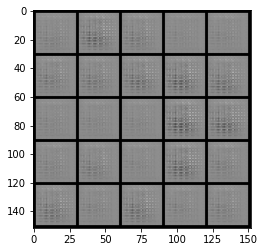

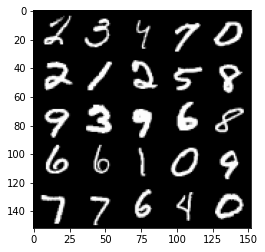

 13%|█▎        | 60/469 [00:01<00:12, 32.67it/s]

Step 1000: Generator loss: 2.5002177941799166, discriminator loss: 0.1370451357811689


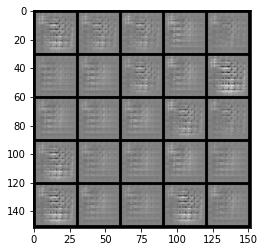

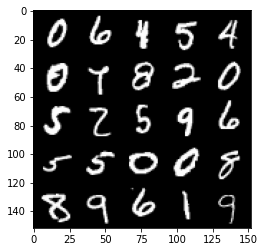

 20%|█▉        | 92/469 [00:02<00:11, 33.29it/s]

Step 1500: Generator loss: 2.9976528130471713, discriminator loss: 0.1739526288211345


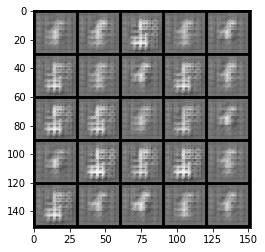

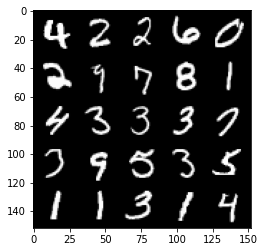

 26%|██▋       | 124/469 [00:03<00:10, 32.23it/s]

Step 2000: Generator loss: 1.7890271315276627, discriminator loss: 0.3468295865505931


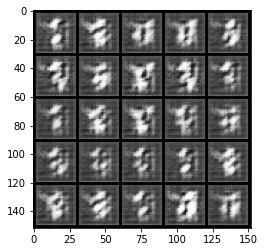

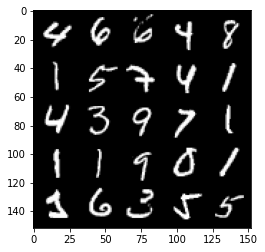

 32%|███▏      | 152/469 [00:04<00:09, 32.32it/s]

Step 2500: Generator loss: 1.3089484205245983, discriminator loss: 0.4737612168192865


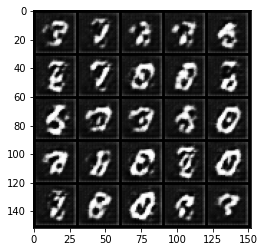

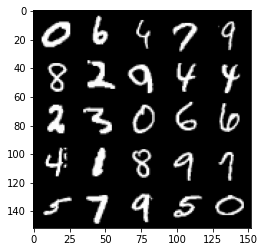

 39%|███▉      | 184/469 [00:05<00:08, 32.28it/s]

Step 3000: Generator loss: 1.0164626164138313, discriminator loss: 0.5420944839715958


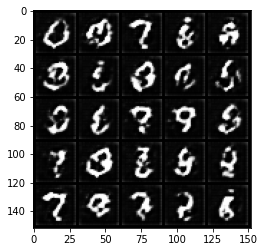

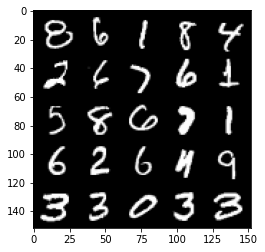

 46%|████▋     | 217/469 [00:06<00:07, 35.11it/s]

Step 3500: Generator loss: 0.9191544364690771, discriminator loss: 0.579746077299118


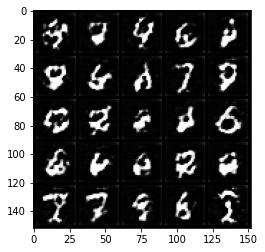

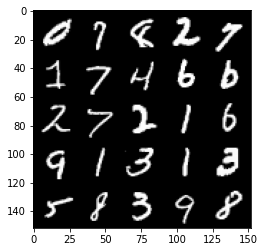

 53%|█████▎    | 248/469 [00:07<00:06, 33.42it/s]

Step 4000: Generator loss: 0.8760715897083289, discriminator loss: 0.6115974316596986


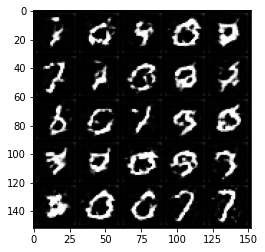

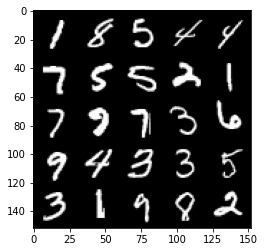

 59%|█████▉    | 277/469 [00:08<00:05, 33.14it/s]

Step 4500: Generator loss: 0.8317597079873095, discriminator loss: 0.6315927103757857


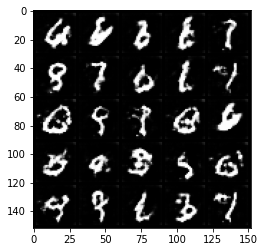

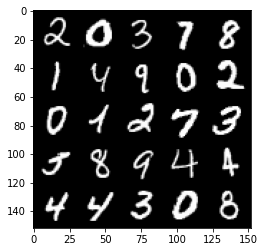

 66%|██████▌   | 308/469 [00:09<00:04, 33.13it/s]

Step 5000: Generator loss: 0.8031510090827946, discriminator loss: 0.6495319349765775


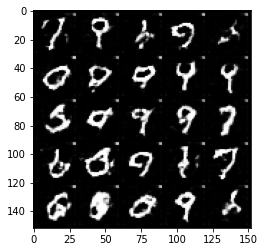

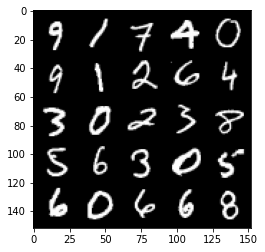

 72%|███████▏  | 340/469 [00:10<00:04, 32.11it/s]

Step 5500: Generator loss: 0.7853652738332746, discriminator loss: 0.6669712958335874


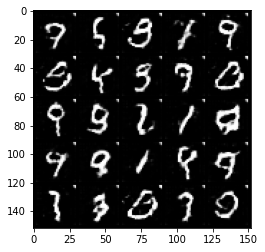

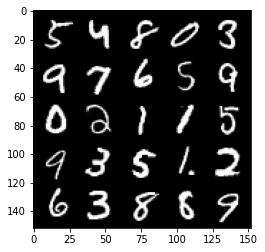

 79%|███████▉  | 372/469 [00:11<00:02, 32.91it/s]

Step 6000: Generator loss: 0.775744440436363, discriminator loss: 0.667757335424424


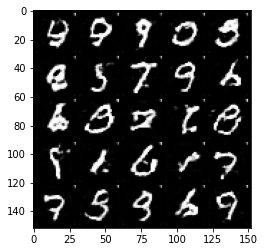

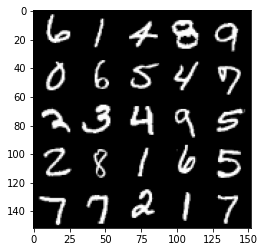

 85%|████████▌ | 400/469 [00:12<00:02, 30.92it/s]

Step 6500: Generator loss: 0.7696096554398518, discriminator loss: 0.6681725244522093


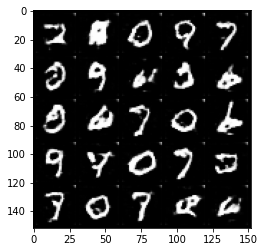

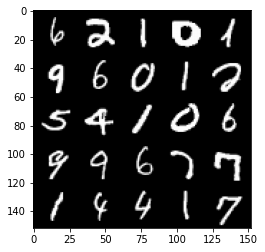

 92%|█████████▏| 431/469 [00:12<00:01, 34.32it/s]

Step 7000: Generator loss: 0.7686714256405827, discriminator loss: 0.6672474995851523


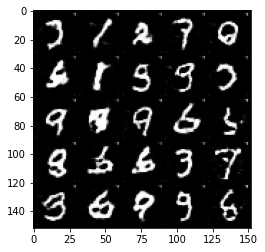

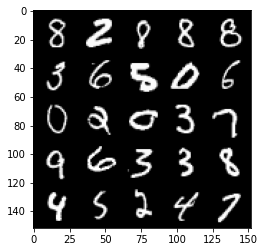

 99%|█████████▉| 464/469 [00:14<00:00, 32.57it/s]

Step 7500: Generator loss: 0.7600030143260954, discriminator loss: 0.6748755935430528


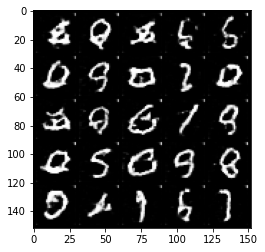

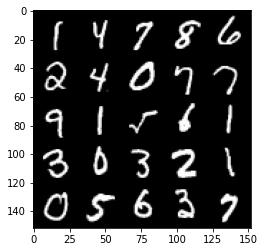

  5%|▌         | 24/469 [00:00<00:12, 35.74it/s]

Step 8000: Generator loss: 0.7494470857381818, discriminator loss: 0.6777096921205522


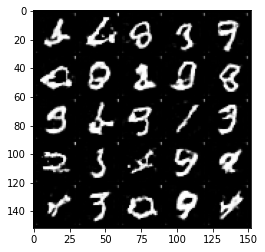

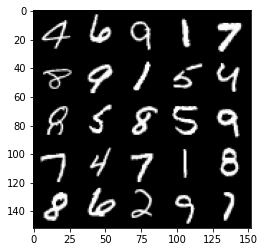

 12%|█▏        | 55/469 [00:01<00:13, 31.60it/s]

Step 8500: Generator loss: 0.7437161493897444, discriminator loss: 0.6810074348449708


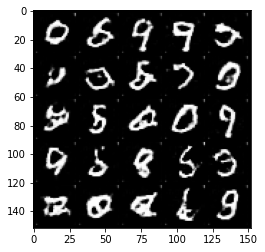

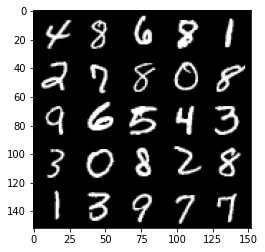

 19%|█▉        | 88/469 [00:02<00:10, 35.08it/s]

Step 9000: Generator loss: 0.7387675734162331, discriminator loss: 0.6871416394710537


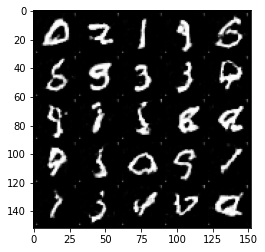

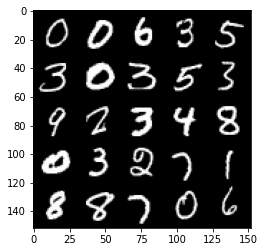

 26%|██▌       | 120/469 [00:03<00:10, 32.72it/s]

Step 9500: Generator loss: 0.7292929030656813, discriminator loss: 0.6884849469661701


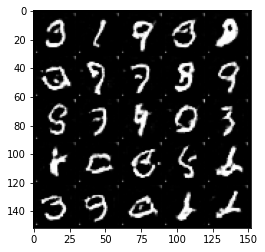

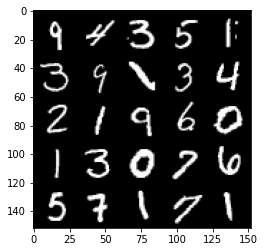

 32%|███▏      | 148/469 [00:04<00:09, 32.94it/s]

Step 10000: Generator loss: 0.729739923298359, discriminator loss: 0.6904953142404557


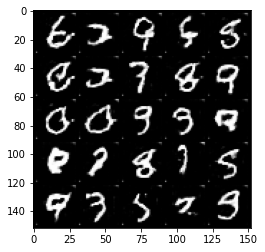

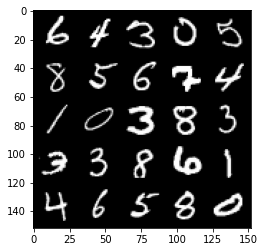

 38%|███▊      | 180/469 [00:05<00:09, 31.89it/s]

Step 10500: Generator loss: 0.7239880305528642, discriminator loss: 0.6950276389122


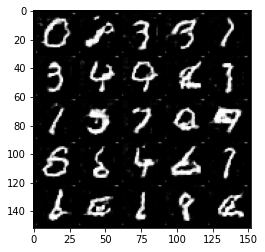

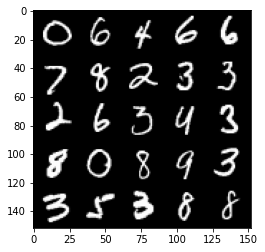

 45%|████▌     | 212/469 [00:06<00:07, 32.81it/s]

Step 11000: Generator loss: 0.721965033888817, discriminator loss: 0.6933311743736263


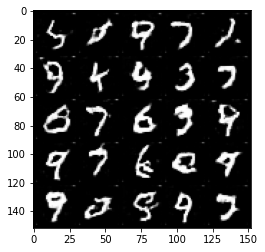

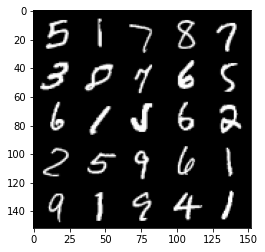

 52%|█████▏    | 244/469 [00:07<00:06, 32.80it/s]

Step 11500: Generator loss: 0.7165987880229945, discriminator loss: 0.695015241980552


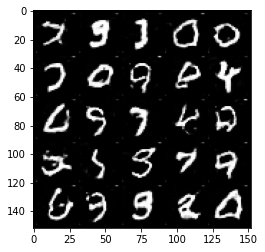

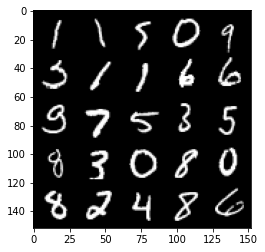

 58%|█████▊    | 272/469 [00:08<00:06, 31.63it/s]

Step 12000: Generator loss: 0.7153122794628151, discriminator loss: 0.6942039468288423


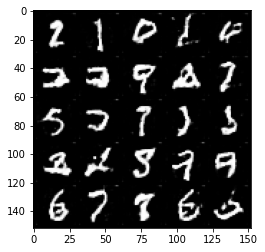

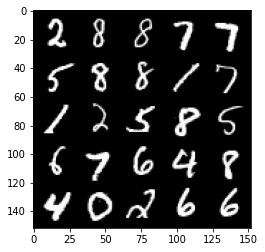

 65%|██████▌   | 305/469 [00:09<00:05, 32.22it/s]

Step 12500: Generator loss: 0.7171716751456263, discriminator loss: 0.6956188987493516


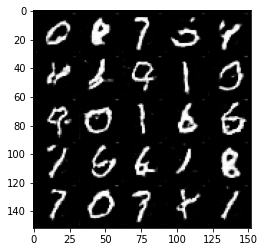

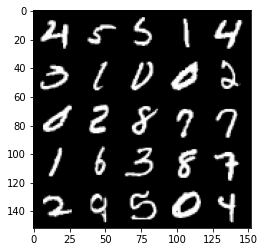

 72%|███████▏  | 336/469 [00:10<00:03, 37.79it/s]

Step 13000: Generator loss: 0.7120036048293118, discriminator loss: 0.6970264701843261


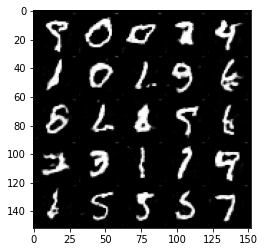

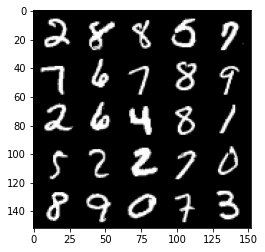

 78%|███████▊  | 368/469 [00:10<00:03, 32.48it/s]

Step 13500: Generator loss: 0.7085128825902938, discriminator loss: 0.696752099990845


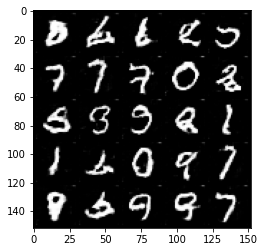

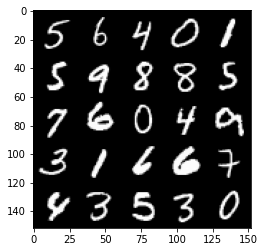

 84%|████████▍ | 396/469 [00:11<00:02, 34.24it/s]

Step 14000: Generator loss: 0.7102803912758827, discriminator loss: 0.6978877251148227


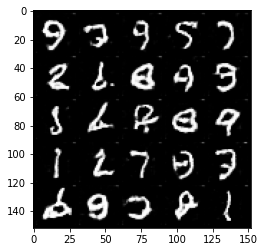

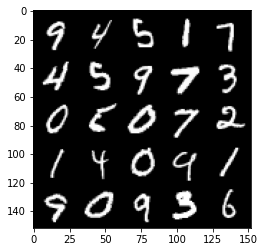

 91%|█████████▏| 429/469 [00:12<00:01, 34.07it/s]

Step 14500: Generator loss: 0.7059220900535585, discriminator loss: 0.6977821577787401


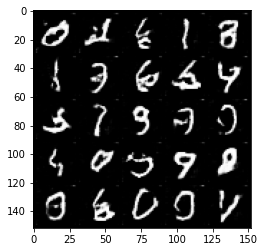

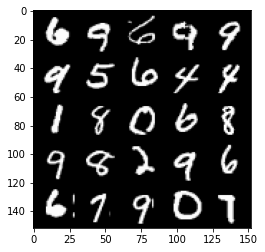

 98%|█████████▊| 458/469 [00:13<00:00, 31.47it/s]

Step 15000: Generator loss: 0.7048016244769099, discriminator loss: 0.6981329426765445


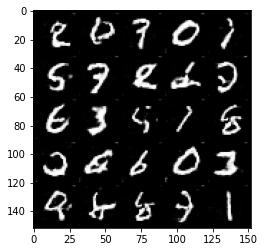

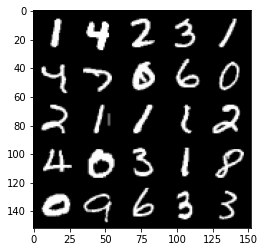

  4%|▍         | 20/469 [00:00<00:13, 32.59it/s]

Step 15500: Generator loss: 0.704877094745636, discriminator loss: 0.6992942399978638


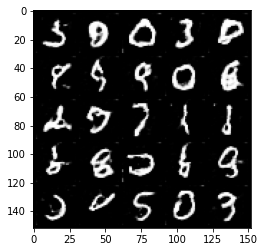

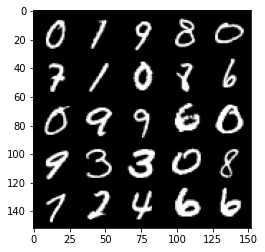

 11%|█         | 52/469 [00:01<00:12, 33.48it/s]

Step 16000: Generator loss: 0.7037558943629255, discriminator loss: 0.6988146271705633


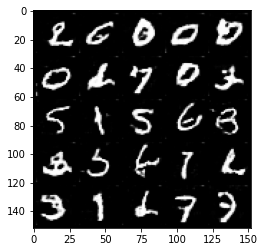

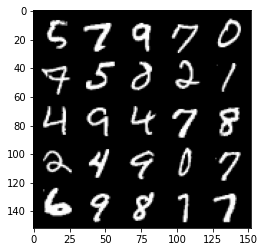

 18%|█▊        | 84/469 [00:02<00:11, 33.15it/s]

Step 16500: Generator loss: 0.7010282502174371, discriminator loss: 0.7000619763135912


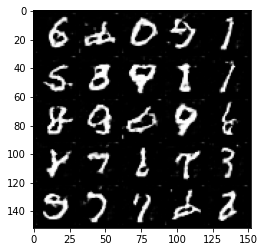

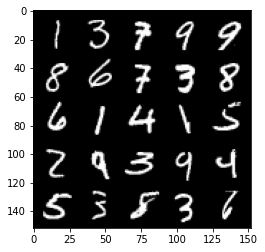

 25%|██▍       | 116/469 [00:03<00:10, 33.34it/s]

Step 17000: Generator loss: 0.7015874741077419, discriminator loss: 0.699826925516128


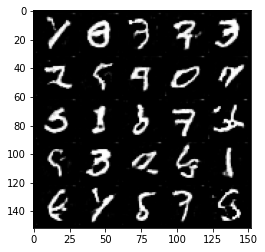

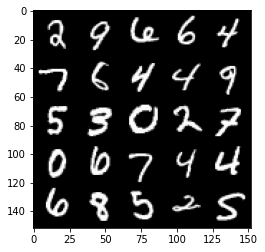

 31%|███       | 145/469 [00:04<00:09, 33.84it/s]

Step 17500: Generator loss: 0.7048859564065932, discriminator loss: 0.6993185170888898


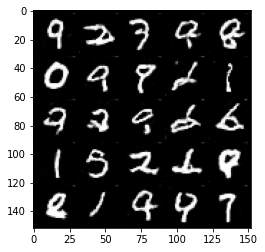

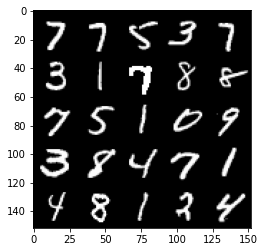

 38%|███▊      | 177/469 [00:05<00:08, 33.81it/s]

Step 18000: Generator loss: 0.7032567816972735, discriminator loss: 0.6996542840003971


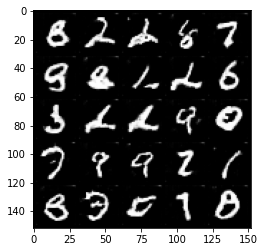

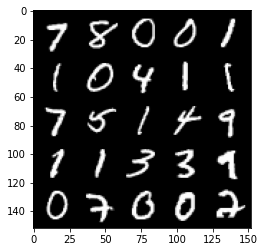

 44%|████▍     | 208/469 [00:06<00:07, 33.69it/s]

Step 18500: Generator loss: 0.7014873062372211, discriminator loss: 0.6983403663635255


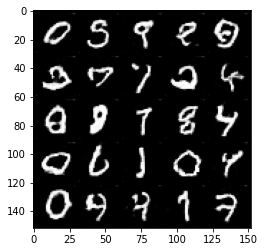

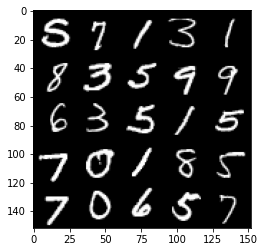

 51%|█████     | 237/469 [00:06<00:06, 33.52it/s]

Step 19000: Generator loss: 0.7039326832890506, discriminator loss: 0.6983640596866605


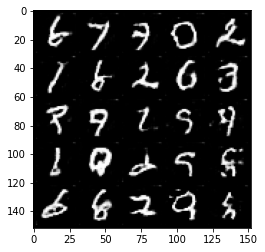

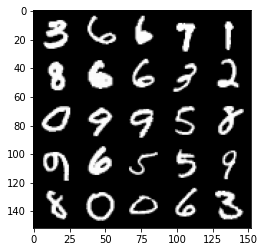

 57%|█████▋    | 269/469 [00:07<00:05, 34.63it/s]

Step 19500: Generator loss: 0.7019307086467742, discriminator loss: 0.6984747557640075


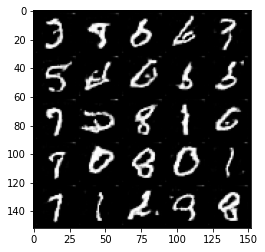

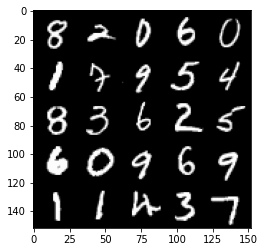

 64%|██████▍   | 301/469 [00:08<00:05, 32.42it/s]

Step 20000: Generator loss: 0.7022799243927005, discriminator loss: 0.6981181447505953


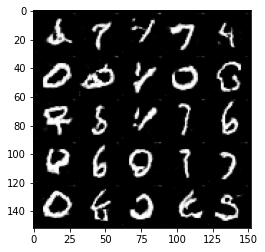

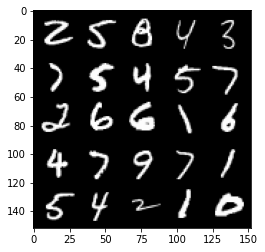

 71%|███████   | 333/469 [00:09<00:04, 33.91it/s]

Step 20500: Generator loss: 0.7003078143596642, discriminator loss: 0.697862131595611


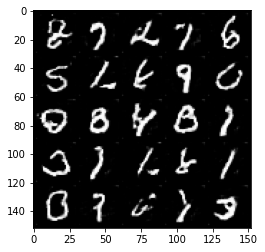

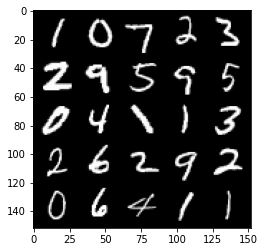

 78%|███████▊  | 364/469 [00:11<00:03, 33.45it/s]

Step 21000: Generator loss: 0.7011321735978134, discriminator loss: 0.6977525161504751


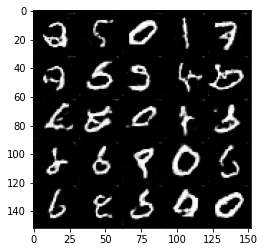

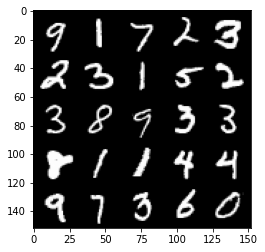

 84%|████████▍ | 394/469 [00:11<00:02, 36.39it/s]

Step 21500: Generator loss: 0.6988159823417669, discriminator loss: 0.6980219663381579


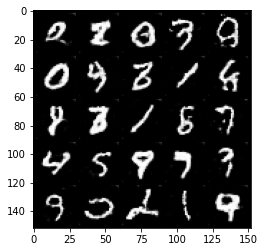

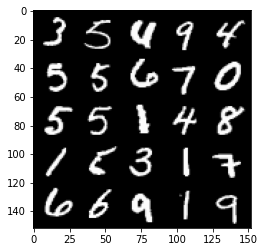

 91%|█████████ | 425/469 [00:12<00:01, 33.83it/s]

Step 22000: Generator loss: 0.6997231051921844, discriminator loss: 0.6967217870950702


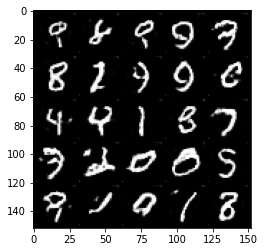

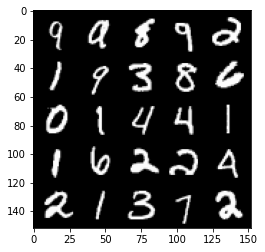

 97%|█████████▋| 454/469 [00:13<00:00, 32.56it/s]

Step 22500: Generator loss: 0.7031106252670297, discriminator loss: 0.696960307955742


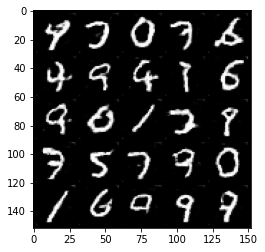

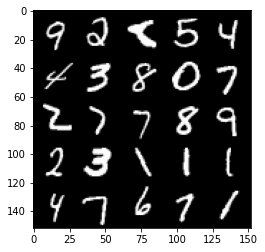

  3%|▎         | 16/469 [00:00<00:13, 34.69it/s]

Step 23000: Generator loss: 0.6992243543863298, discriminator loss: 0.6963718961477287


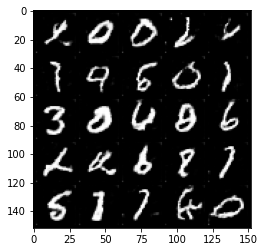

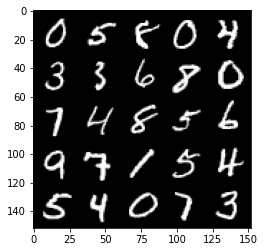

100%|██████████| 469/469 [00:14<00:00, 33.05it/s]


In [26]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1